In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import tree
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, f1_score
from sklearn.feature_selection import RFE
import itertools
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from tabulate import tabulate
import optuna
import time

C:\Users\hashi\AppData\Local\Temp\ipykernel_18348\1886673810.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
train = pd.read_csv('Train_data.csv')
test = pd.read_csv('Test_data.csv')

In [3]:
# Initial Exploration
print(train.head())
print(train.info())
print(train.describe())
print(train.describe(include='object'))

   duration protocol_type   service flag  src_bytes  dst_bytes  land  \
0         0           tcp  ftp_data   SF        491          0     0   
1         0           udp     other   SF        146          0     0   
2         0           tcp   private   S0          0          0     0   
3         0           tcp      http   SF        232       8153     0   
4         0           tcp      http   SF        199        420     0   

   wrong_fragment  urgent  hot  ...  dst_host_srv_count  \
0               0       0    0  ...                  25   
1               0       0    0  ...                   1   
2               0       0    0  ...                  26   
3               0       0    0  ...                 255   
4               0       0    0  ...                 255   

   dst_host_same_srv_rate  dst_host_diff_srv_rate  \
0                    0.17                    0.03   
1                    0.00                    0.60   
2                    0.10                    0.05   


No missing values found.
Number of duplicate rows: 0
Class distribution Training set:
class
normal     13449
anomaly    11743
Name: count, dtype: int64


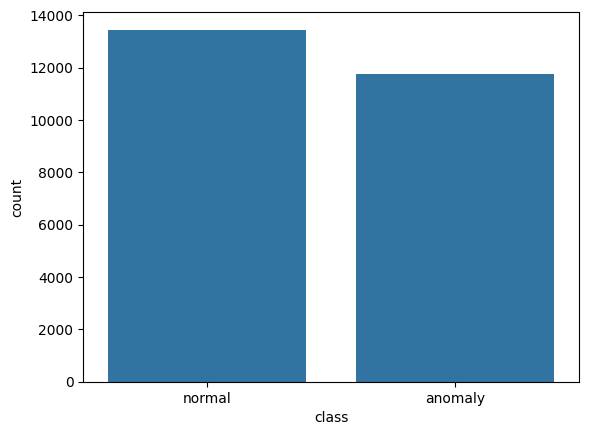

In [4]:
# Check for Missing Values
total_rows = train.shape[0]
missing_columns = [col for col in train.columns if train[col].isnull().any()]

if missing_columns:
    print("Missing Values:")
    for col in missing_columns:
        null_count = train[col].isnull().sum()
        null_percentage = (null_count / total_rows) * 100
        print(f"{col}: {null_count} ({round(null_percentage, 3)}%)")
else:
    print("No missing values found.")

# Check for Duplicate Rows
duplicate_rows = train.duplicated().sum()
print(f"Number of duplicate rows: {duplicate_rows}")

# Plot Class Distribution
sns.countplot(x=train['class'])

# Print Class Distribution
print('Class distribution Training set:')
print(train['class'].value_counts())

In [5]:
# Label Encoding
from sklearn.preprocessing import LabelEncoder

def label_encode(df):
    """Applies label encoding to categorical columns in a DataFrame."""
    for col in df.columns:
        if df[col].dtype == 'object':
            le = LabelEncoder()
            df[col] = le.fit_transform(df[col])

# Apply label encoding to training and testing datasets
label_encode(train)
label_encode(test)

In [6]:
# Drop unnecessary columns
train.drop(['num_outbound_cmds'], axis=1, inplace=True)
test.drop(['num_outbound_cmds'], axis=1, inplace=True)

In [7]:
# Define Features and Labels
X_train = train.drop(['class'], axis=1)
Y_train = train['class']

In [8]:
# Feature Selection
rfc = RandomForestClassifier()
rfe = RFE(rfc, n_features_to_select=10)
rfe = rfe.fit(X_train, Y_train)
selected_features = [v for i, v in zip(rfe.get_support(), X_train.columns) if i]

X_train = X_train[selected_features]
test = test[selected_features]

In [9]:
# Feature Scaling
scale = StandardScaler()
X_train = scale.fit_transform(X_train)
test = scale.transform(test)

In [10]:
# Train-Test Split
x_train, x_test, y_train, y_test = train_test_split(X_train, Y_train, train_size=0.70, random_state=2)

In [11]:
# Logistic Regression
lg_model = LogisticRegression(max_iter=1200000, random_state=42)
lg_model.fit(x_train, y_train)
lg_train, lg_test = lg_model.score(x_train, y_train), lg_model.score(x_test, y_test)
print(f"Logistic Regression - Training Score: {lg_train}, Test Score: {lg_test}")

Logistic Regression - Training Score: 0.9287739593966202, Test Score: 0.9231278115903678


In [12]:
# k-NN
def knn_objective(trial):
    n_neighbors = trial.suggest_int('KNN_n_neighbors', 2, 16, log=False)
    classifier_obj = KNeighborsClassifier(n_neighbors=n_neighbors)
    classifier_obj.fit(x_train, y_train)
    accuracy = classifier_obj.score(x_test, y_test)
    return accuracy

study_KNN = optuna.create_study(direction='maximize')
study_KNN.optimize(knn_objective, n_trials=1)
print(study_KNN.best_trial)

KNN_model = KNeighborsClassifier(n_neighbors=study_KNN.best_trial.params['KNN_n_neighbors'])
KNN_model.fit(x_train, y_train)
KNN_train, KNN_test = KNN_model.score(x_train, y_train), KNN_model.score(x_test, y_test)
print(f"k-NN - Train Score: {KNN_train}, Test Score: {KNN_test}")

[I 2024-08-06 11:55:22,081] A new study created in memory with name: no-name-9edc03e7-2f09-4a32-93db-bad1be1d7882
[I 2024-08-06 11:55:25,118] Trial 0 finished with value: 0.9829319925906325 and parameters: {'KNN_n_neighbors': 2}. Best is trial 0 with value: 0.9829319925906325.


FrozenTrial(number=0, state=1, values=[0.9829319925906325], datetime_start=datetime.datetime(2024, 8, 6, 11, 55, 22, 86348), datetime_complete=datetime.datetime(2024, 8, 6, 11, 55, 25, 118000), params={'KNN_n_neighbors': 2}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'KNN_n_neighbors': IntDistribution(high=16, log=False, low=2, step=1)}, trial_id=0, value=None)
k-NN - Train Score: 0.9920607916524895, Test Score: 0.9829319925906325


In [13]:
# Decision Tree
def dt_objective(trial):
    dt_max_depth = trial.suggest_int('dt_max_depth', 2, 32, log=False)
    dt_max_features = trial.suggest_int('dt_max_features', 2, 10, log=False)
    classifier_obj = DecisionTreeClassifier(max_features=dt_max_features, max_depth=dt_max_depth)
    classifier_obj.fit(x_train, y_train)
    accuracy = classifier_obj.score(x_test, y_test)
    return accuracy

study_dt = optuna.create_study(direction='maximize')
study_dt.optimize(dt_objective, n_trials=30)
print(study_dt.best_trial)

dt_model = DecisionTreeClassifier(max_features=study_dt.best_trial.params['dt_max_features'], max_depth=study_dt.best_trial.params['dt_max_depth'])
dt_model.fit(x_train, y_train)
dt_train, dt_test = dt_model.score(x_train, y_train), dt_model.score(x_test, y_test)
print(f"Decision Tree - Train Score: {dt_train}, Test Score: {dt_test}")

[I 2024-08-06 11:55:31,057] A new study created in memory with name: no-name-0b511e6c-5fad-49df-8330-689d714d4089
[I 2024-08-06 11:55:31,150] Trial 0 finished with value: 0.9937814236570521 and parameters: {'dt_max_depth': 9, 'dt_max_features': 8}. Best is trial 0 with value: 0.9937814236570521.
[I 2024-08-06 11:55:31,241] Trial 1 finished with value: 0.9941783540619211 and parameters: {'dt_max_depth': 29, 'dt_max_features': 10}. Best is trial 1 with value: 0.9941783540619211.
[I 2024-08-06 11:55:31,302] Trial 2 finished with value: 0.9948399047367028 and parameters: {'dt_max_depth': 19, 'dt_max_features': 7}. Best is trial 2 with value: 0.9948399047367028.
[I 2024-08-06 11:55:31,386] Trial 3 finished with value: 0.9952368351415718 and parameters: {'dt_max_depth': 30, 'dt_max_features': 9}. Best is trial 3 with value: 0.9952368351415718.
[I 2024-08-06 11:55:31,464] Trial 4 finished with value: 0.9936491135220958 and parameters: {'dt_max_depth': 11, 'dt_max_features': 8}. Best is trial 

FrozenTrial(number=28, state=1, values=[0.9953691452765282], datetime_start=datetime.datetime(2024, 8, 6, 11, 55, 33, 334892), datetime_complete=datetime.datetime(2024, 8, 6, 11, 55, 33, 433012), params={'dt_max_depth': 32, 'dt_max_features': 9}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'dt_max_depth': IntDistribution(high=32, log=False, low=2, step=1), 'dt_max_features': IntDistribution(high=10, log=False, low=2, step=1)}, trial_id=28, value=None)
Decision Tree - Train Score: 1.0, Test Score: 0.9956337655464409


Random Forest Classifier - Training Accuracy: 1.0
Random Forest Classifier - Testing Accuracy: 0.9965599364911352
Confusion Matrix:
[[3485   13]
 [  13 4047]]
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3498
           1       1.00      1.00      1.00      4060

    accuracy                           1.00      7558
   macro avg       1.00      1.00      1.00      7558
weighted avg       1.00      1.00      1.00      7558



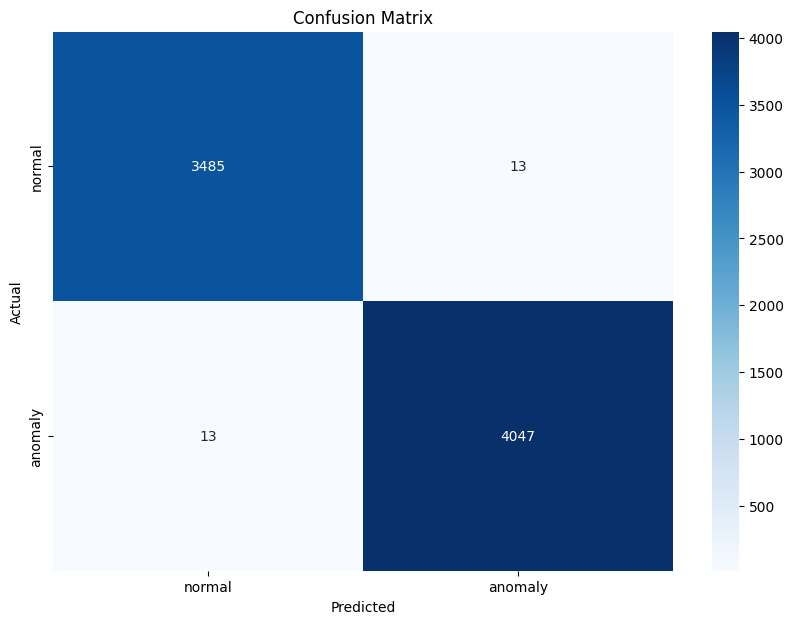

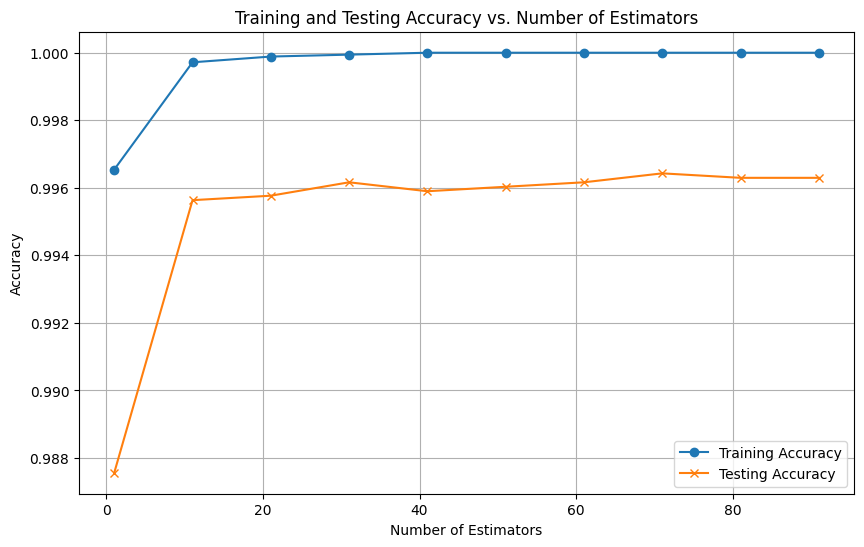

In [14]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import pickle

# Load data
train = pd.read_csv('Train_data.csv')
test = pd.read_csv('Test_data.csv')

# Label Encoding
def label_encode(df):
    for col in df.columns:
        if df[col].dtype == 'object':
            le = LabelEncoder()
            df[col] = le.fit_transform(df[col])

label_encode(train)
label_encode(test)

# Drop unnecessary columns
train.drop(['num_outbound_cmds'], axis=1, inplace=True)
test.drop(['num_outbound_cmds'], axis=1, inplace=True)

# Define Features and Labels
X_train = train.drop(['class'], axis=1)
Y_train = train['class']

# Feature Selection
from sklearn.feature_selection import RFE
rfc = RandomForestClassifier()
rfe = RFE(rfc, n_features_to_select=10)
rfe = rfe.fit(X_train, Y_train)
selected_features = [v for i, v in zip(rfe.get_support(), X_train.columns) if i]

X_train = X_train[selected_features]
test = test[selected_features]

# Feature Scaling
scale = StandardScaler()
X_train = scale.fit_transform(X_train)
test = scale.transform(test)

# Train-Test Split
x_train, x_test, y_train, y_test = train_test_split(X_train, Y_train, train_size=0.70, random_state=2)

# Train Random Forest classifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(x_train, y_train)

# Make predictions
y_train_pred = rf_model.predict(x_train)
y_test_pred = rf_model.predict(x_test)

# Evaluate model
print("Random Forest Classifier - Training Accuracy:", accuracy_score(y_train, y_train_pred))
print("Random Forest Classifier - Testing Accuracy:", accuracy_score(y_test, y_test_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_test_pred))
print("Classification Report:")
print(classification_report(y_test, y_test_pred))

# Confusion Matrix Heatmap
conf_matrix = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(10,7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=["normal", "anomaly"], yticklabels=["normal", "anomaly"])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Plotting training and testing accuracy
train_accuracies = []
test_accuracies = []
estimators_range = range(1, 101, 10)

for n_estimators in estimators_range:
    rf_model = RandomForestClassifier(n_estimators=n_estimators, random_state=42)
    rf_model.fit(x_train, y_train)
    train_accuracies.append(rf_model.score(x_train, y_train))
    test_accuracies.append(rf_model.score(x_test, y_test))

plt.figure(figsize=(10, 6))
plt.plot(estimators_range, train_accuracies, label='Training Accuracy', marker='o')
plt.plot(estimators_range, test_accuracies, label='Testing Accuracy', marker='x')
plt.xlabel('Number of Estimators')
plt.ylabel('Accuracy')
plt.title('Training and Testing Accuracy vs. Number of Estimators')
plt.legend()
plt.grid()
plt.show()



In [15]:
# Support Vector Machine
svm_model = SVC(kernel='linear', random_state=42)
start_time = time.time()
svm_model.fit(x_train, y_train)
end_time = time.time()
print("SVM Training time: ", end_time-start_time)

start_time = time.time()
y_test_pred = svm_model.predict(x_train)
end_time = time.time()
print("SVM Testing time: ", end_time-start_time)

svm_train, svm_test = svm_model.score(x_train, y_train), svm_model.score(x_test, y_test)
print(f"SVM - Train Score: {svm_train}, Test Score: {svm_test}")

SVM Training time:  8.193295240402222
SVM Testing time:  1.3982086181640625
SVM - Train Score: 0.9462402177611432, Test Score: 0.9439005027785128


*************** KNeighborsClassifier Model Validation ***************
Mean precision: 99.17% ± 0.31

Mean recall: 97.49% ± 0.56

**************** LogisticRegression Model Validation ****************
Mean precision: 93.55% ± 0.58

Mean recall: 95.62% ± 0.6

************** DecisionTreeClassifier Model Validation **************
Mean precision: 99.5% ± 0.18

Mean recall: 99.38% ± 0.21

************************ SVM Model Validation ************************
Mean precision: 93.82% ± 0.64

Mean recall: 96.14% ± 0.63

******************* RandomForest Model Validation *******************
Mean precision: 99.55% ± 0.2

Mean recall: 99.82% ± 0.12



C:\Users\hashi\AppData\Local\Temp\ipykernel_18348\2092846385.py:42: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  scores_df = pd.DataFrame(scores).swapaxes("index", "columns") * 100


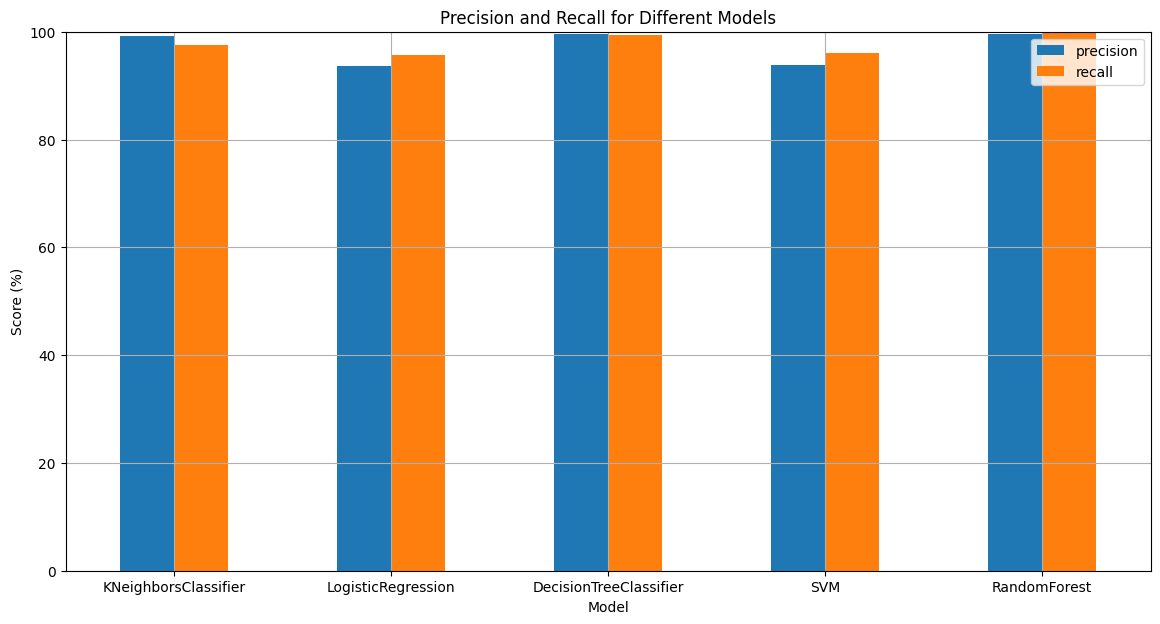

╒════════════════════════╤═══════════════╤══════════════╕
│ Model                  │   Train Score │   Test Score │
╞════════════════════════╪═══════════════╪══════════════╡
│ KNeighborsClassifier   │      0.992061 │     0.982932 │
├────────────────────────┼───────────────┼──────────────┤
│ LogisticRegression     │      0.928774 │     0.923128 │
├────────────────────────┼───────────────┼──────────────┤
│ DecisionTreeClassifier │      1        │     0.995634 │
├────────────────────────┼───────────────┼──────────────┤
│ SVM                    │      0.94624  │     0.943901 │
├────────────────────────┼───────────────┼──────────────┤
│ RandomForest           │      1        │     0.996295 │
╘════════════════════════╧═══════════════╧══════════════╛


In [17]:
from sklearn.model_selection import cross_val_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tabulate import tabulate


# Calculate scores for Random Forest
rf_train_score = rf_model.score(x_train, y_train)
rf_test_score = rf_model.score(x_test, y_test)

# Define the models including the Random Forest
models = {
    'KNeighborsClassifier': KNN_model,
    'LogisticRegression': lg_model,
    'DecisionTreeClassifier': dt_model,
    'SVM': svm_model,
    'RandomForest': rf_model
}

scores = {}
for name in models:
    scores[name] = {}
    for scorer in ['precision', 'recall']:
        scores[name][scorer] = cross_val_score(models[name], x_train, y_train, cv=10, scoring=scorer)

def line(name):
    return '*' * (25 - len(name) // 2)

for name in models:
    print(line(name), name, 'Model Validation', line(name))
    for scorer in ['precision', 'recall']:
        mean = round(np.mean(scores[name][scorer]) * 100, 2)
        stdev = round(np.std(scores[name][scorer]) * 100, 2)
        print(f"Mean {scorer}: {mean}% ± {stdev}\n")

# Convert scores to a DataFrame
for name in models:
    for scorer in ['precision', 'recall']:
        scores[name][scorer] = scores[name][scorer].mean()

scores_df = pd.DataFrame(scores).swapaxes("index", "columns") * 100

# Plot the results
scores_df.plot(kind="bar", ylim=[0, 100], figsize=(14, 7), rot=0)
plt.title('Precision and Recall for Different Models')
plt.xlabel('Model')
plt.ylabel('Score (%)')
plt.grid(True)
plt.show()

# Model Comparison Table
data = [
    ["KNeighborsClassifier", KNN_train, KNN_test], 
    ["LogisticRegression", lg_train, lg_test],
    ["DecisionTreeClassifier", dt_train, dt_test],
    ["SVM", svm_train, svm_test],
    ["RandomForest", rf_train_score, rf_test_score]
]

col_names = ["Model", "Train Score", "Test Score"]
print(tabulate(data, headers=col_names, tablefmt="fancy_grid"))


In [18]:
# Model Predictions
preds = {}
for name in models:
    preds[name] = models[name].predict(x_test)

In [19]:
# Confusion Matrix and Classification Report
target_names = ["normal", "anomaly"]
for name in models:
    print(line(name), name, 'Model Testing', line(name))
    print(confusion_matrix(y_test, preds[name]))
    print('-' * len(name))  # Print a line of '-' characters with the same length as the name
    print(classification_report(y_test, preds[name], target_names=target_names))

*************** KNeighborsClassifier Model Testing ***************
[[3315  183]
 [ 228 3832]]
--------------------
              precision    recall  f1-score   support

      normal       0.94      0.95      0.94      3498
     anomaly       0.95      0.94      0.95      4060

    accuracy                           0.95      7558
   macro avg       0.95      0.95      0.95      7558
weighted avg       0.95      0.95      0.95      7558

**************** LogisticRegression Model Testing ****************
[[3202  296]
 [ 210 3850]]
------------------
              precision    recall  f1-score   support

      normal       0.94      0.92      0.93      3498
     anomaly       0.93      0.95      0.94      4060

    accuracy                           0.93      7558
   macro avg       0.93      0.93      0.93      7558
weighted avg       0.93      0.93      0.93      7558

************** DecisionTreeClassifier Model Testing **************
[[3394  104]
 [  35 4025]]
----------------------
 

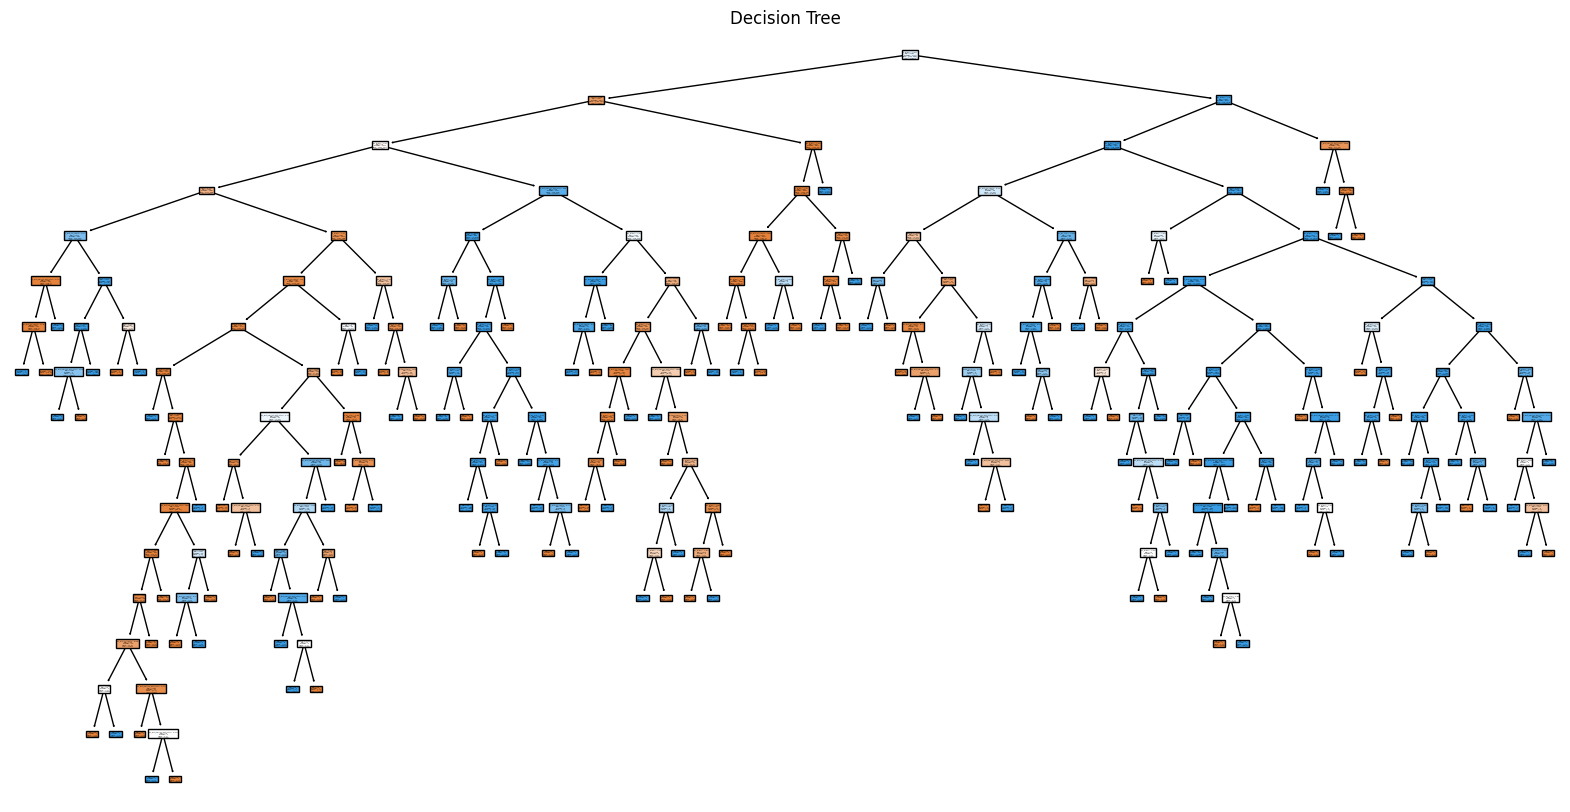

In [20]:
# Visualizing Decision Tree
plt.figure(figsize=(20,10))
tree.plot_tree(dt_model, filled=True, feature_names=selected_features, class_names=target_names)
plt.title("Decision Tree")
plt.show()

In [21]:
# Visualizing Decision Boundaries for k-NN, SVM, and Logistic Regression
# For visualization, use only the first two features
def plot_decision_boundaries(model, x, y, title):
    plt.figure(figsize=(10, 6))
    plot_decision_regions(x, y, clf=model, legend=2)
    plt.title(title)
    plt.show()

x_train_2d = x_train[:, :2]
x_test_2d = x_test[:, :2]



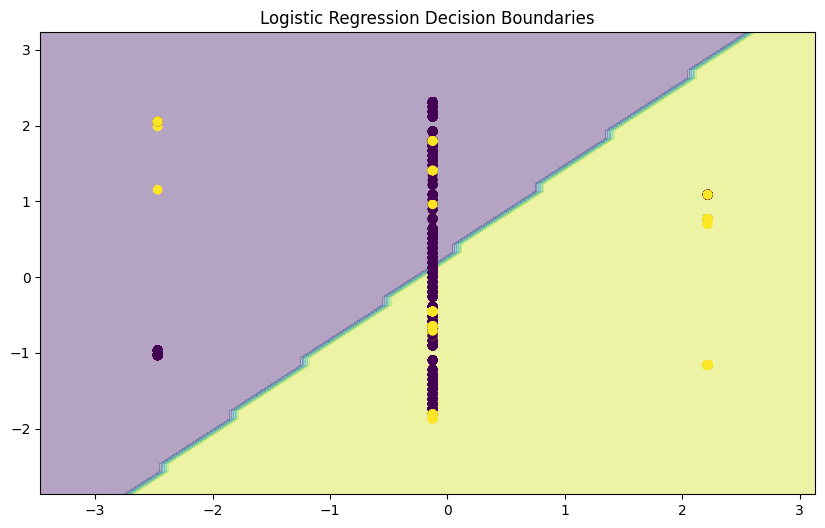

In [22]:
# Logistic Regression
# Import necessary libraries
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import numpy as np

# Assuming you have your data and model defined
lg_2d = LogisticRegression(max_iter=1200000, random_state=42)
lg_2d.fit(x_train_2d, y_train)

# Function to plot decision boundaries
def plot_decision_boundaries(model, x, y, title):
    plt.figure(figsize=(10, 6))
    x_min, x_max = x[:, 0].min() - 1, x[:, 0].max() + 1
    y_min, y_max = x[:, 1].min() - 1, x[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, alpha=0.4)
    plt.scatter(x[:, 0], x[:, 1], c=y)
    plt.title(title)
    plt.show()

# Plot decision boundaries
plot_decision_boundaries(lg_2d, x_test_2d, y_test, "Logistic Regression Decision Boundaries")

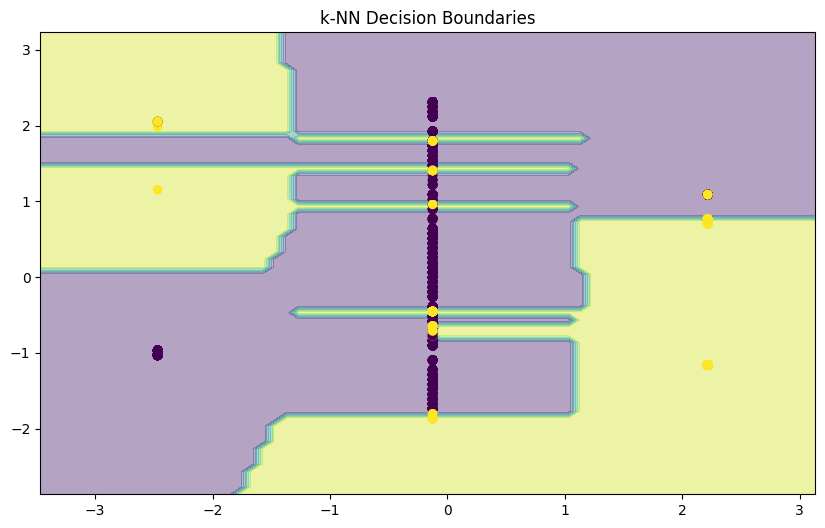

In [23]:
# k-NN
# Train a KNN classifier with the optimal number of neighbors
knn_2d = KNeighborsClassifier(n_neighbors=study_KNN.best_trial.params['KNN_n_neighbors'])

# Fit the classifier to the 2D training data
knn_2d.fit(x_train_2d, y_train)

# Plot the decision boundaries of the KNN classifier
plot_decision_boundaries(knn_2d, x_test_2d, y_test, "k-NN Decision Boundaries")

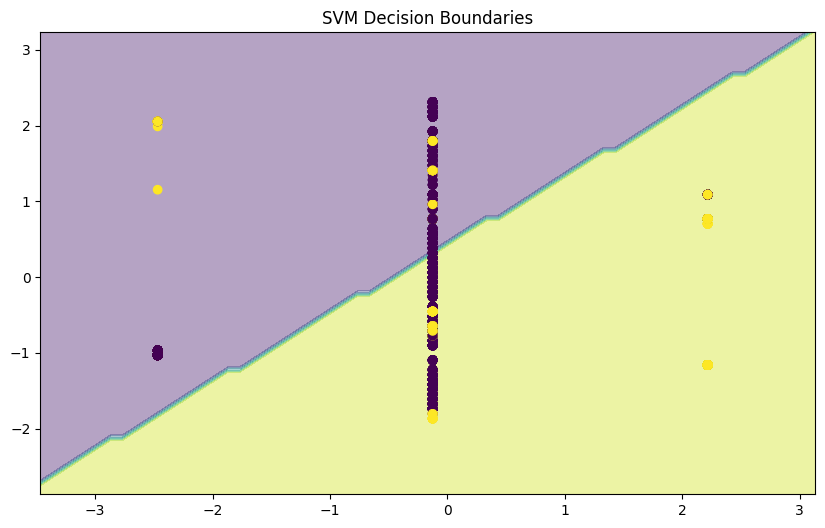

In [24]:
### Support Vector Machine (SVM)

# Train a linear SVM classifier
from sklearn.svm import SVC
svm_2d = SVC(kernel='linear')

# Fit the classifier to the 2D training data
svm_2d.fit(x_train_2d, y_train)

# Plot the decision boundaries of the SVM classifier
plot_decision_boundaries(svm_2d, x_test_2d, y_test, "SVM Decision Boundaries")

In [25]:
# Stacking Ensemble
from sklearn.ensemble import StackingClassifier
estimators = [
    ('knn', KNN_model),
    ('lr', lg_model),
    ('dt', dt_model),
    ('svm', svm_model)
]

stacking_clf = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression())
stacking_clf.fit(x_train, y_train)
stacking_train_score = stacking_clf.score(x_train, y_train)
stacking_test_score = stacking_clf.score(x_test, y_test)
print(f"Stacking - Train Score: {stacking_train_score}, Test Score: {stacking_test_score}")

Stacking - Train Score: 1.0, Test Score: 0.9936491135220958


# Now Intrusion Prevention using random forest as it is fast and more accurate than others 


In [27]:
import pickle
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Load data
train = pd.read_csv('Train_data.csv')
test = pd.read_csv('Test_data.csv')

# Label Encoding
def label_encode(df):
    for col in df.columns:
        if df[col].dtype == 'object':
            le = LabelEncoder()
            df[col] = le.fit_transform(df[col])

label_encode(train)
label_encode(test)

# Drop unnecessary columns
train.drop(['num_outbound_cmds'], axis=1, inplace=True)
test.drop(['num_outbound_cmds'], axis=1, inplace=True)

# Define Features and Labels
X_train = train.drop(['class'], axis=1)
Y_train = train['class']

# Feature Selection
from sklearn.feature_selection import RFE
rfc = RandomForestClassifier()
rfe = RFE(rfc, n_features_to_select=10)
rfe = rfe.fit(X_train, Y_train)
selected_features = [v for i, v in zip(rfe.get_support(), X_train.columns) if i]

X_train = X_train[selected_features]
test = test[selected_features]

# Feature Scaling
scale = StandardScaler()
X_train = scale.fit_transform(X_train)
test = scale.transform(test)

# Train-Test Split
x_train, x_test, y_train, y_test = train_test_split(X_train, Y_train, train_size=0.70, random_state=2)

# Define the model
rfc = RandomForestClassifier(n_estimators=100)

# Training part
rfc.fit(x_train, y_train)

# Save the trained model to a file
with open('random_forest_clf.pkl', 'wb') as file:
    pickle.dump(rfc, file)
print("Model saved successfully.")


with open('random_forest_clf.pkl', 'rb') as file:
    loaded_model = pickle.load(file)
print("Model loaded successfully.")




Model saved successfully.
Model loaded successfully.


In [29]:
# Read new incoming data
incoming_data = pd.read_csv('intrusionCheck.csv')
label_encode(incoming_data)
incoming_data = incoming_data[selected_features]
incoming_data = scale.transform(incoming_data)

# Predict using the loaded model
predictions = loaded_model.predict(incoming_data)
malicious_indices = [i for i, pred in enumerate(predictions) if pred == 0]

if malicious_indices:
    print(f"Malicious data detected at indices: {malicious_indices}")
    print("Firewalls blocked those data ")
    # for i in malicious_indices:
    #     entry = incoming_data.iloc[i]['ip_or_domain']
    #     if entry.replace('.', '').isdigit():  # Check if the entry is an IP address
    #         block_ip(entry)
    #     else:
    #         block_domain(entry)
else:
    print("No malicious data detected.")

Malicious data detected at indices: [0, 1, 3, 12, 13, 19, 20, 21, 24, 25, 28, 33, 34, 35, 40, 44, 46, 47, 48, 52, 53, 56, 64, 66, 67, 68, 70, 74, 80, 81, 82, 86, 87, 92, 93, 95, 98, 99, 100, 102, 103, 105, 108, 111, 115, 117, 118, 121, 122, 123, 127, 136, 138, 142, 143, 145, 146, 147, 151, 152, 155, 157, 158, 159, 160, 161, 162, 163, 165, 166, 169, 172, 173, 176, 177, 180, 186, 187, 189, 192, 198, 205, 206, 215, 223, 225, 227, 231, 234, 235, 243, 244, 247, 248, 254, 255, 256, 263, 264, 265, 269, 270, 272, 273, 274, 276, 278, 279, 283, 284, 287, 291, 292, 296, 298, 300, 301, 306, 308, 309, 310, 315, 318, 323, 325, 326, 328, 329, 330, 332, 334, 338, 339, 340, 344, 345, 347, 350, 351, 359, 362, 367, 371, 372, 375, 378, 382, 386, 392, 393, 396, 400, 403, 405, 409, 413, 416, 417, 420, 423, 425, 427, 428, 429, 430, 433, 434, 437, 438, 444, 446, 449, 452, 453, 456, 457, 458, 461, 464, 465, 470, 471, 473, 476, 481, 484, 485, 488, 492, 493, 494, 495, 496, 498, 501, 503, 504, 505, 508, 514, 515,